In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")  # Seaborn varsayılanlarını bozma
sns.set(rc={"figure.dpi": 110})


In [2]:
import bz2, itertools, pandas as pd, numpy as np

DATA_PATH = "/kaggle/input/amazonreviews/train.ft.txt.bz2"

def read_fasttext_chunked(path: str, chunk_size: int = 100_000):
    """
    fastText formatındaki satırları ('__label__X <metin>') chunk'lar hâlinde
    okur ve DataFrame olarak yield eder.

    Parameters
    ----------
    path : str
        .txt veya .bz2 dosya yolu
    chunk_size : int
        Her seferde okunacak satır sayısı

    Yields
    ------
    pd.DataFrame
        Kolonlar: 'label' (0=negatif, 1=pozitif), 'text'
    """
    open_fn = bz2.open if path.endswith(".bz2") else open

    labels, texts = [], []
    with open_fn(path, mode="rt", encoding="utf-8", errors="ignore") as f:
        for i, line in enumerate(f, 1):
            parts = line.rstrip("\n").split(" ", 1)
            if len(parts) != 2:
                continue  # bozuk satır
            lab, txt = parts
            labels.append(1 if lab == "__label__2" else 0)
            texts.append(txt)

            if i % chunk_size == 0:
                df_chunk = pd.DataFrame({"label": labels, "text": texts})
                df_chunk["label"] = df_chunk["label"].astype(np.int8)
                yield df_chunk
                labels, texts = [], []  # listeleri sıfırla

        if labels:  # son kalan satırlar
            df_chunk = pd.DataFrame({"label": labels, "text": texts})
            df_chunk["label"] = df_chunk["label"].astype(np.int8)
            yield df_chunk

# ──────────────────────────────── ÖRNEKLEM ────────────────────────────────
sample_chunks = []
for idx, chunk in enumerate(read_fasttext_chunked(DATA_PATH, chunk_size=100_000)):
    sample_chunks.append(chunk)
    if idx >= 1:           # ilk 2 chunk ≈ 500 000 satır
        break

df = pd.concat(sample_chunks, ignore_index=True)

print(f"Yüklenen örneklem boyutu: {len(df):,} satır")
print(f"Bellek kullanımı: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


Yüklenen örneklem boyutu: 200,000 satır
Bellek kullanımı: 95.22 MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   200000 non-null  int8  
 1   text    200000 non-null  object
dtypes: int8(1), object(1)
memory usage: 1.7+ MB


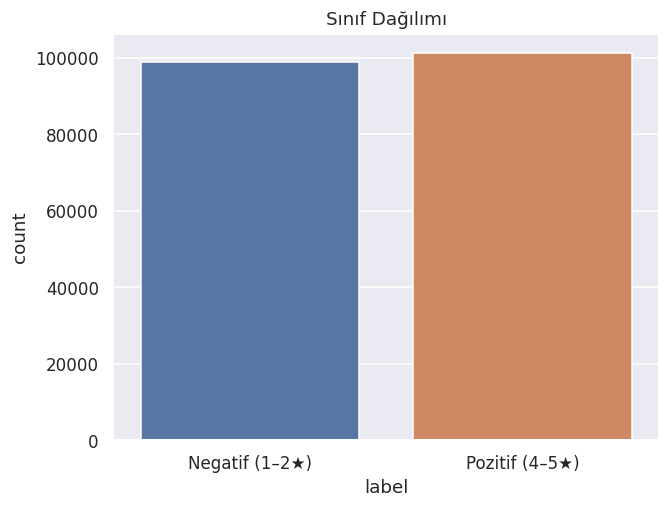

label
1    50.58
0    49.42
Name: proportion, dtype: float64


In [3]:

df.info()


import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x="label", data=df)
plt.xticks([0, 1], ["Negatif (1–2★)", "Pozitif (4–5★)"])
plt.title("Sınıf Dağılımı")
plt.show()

# Yüzde olarak da raporla
print(
    df["label"]
      .value_counts(normalize=True)
      .mul(100)
      .round(2)
)


### 3.3  İki Farklı Normalizasyon Çıktısı (Stemming vs Lemmatization)

Aşağıdaki kod:
1. Tek temizlik fonksiyonu içinde `mode` parametresiyle “stem” / “lemma” seçer.  
2. **İki yeni sütun** ekler:  
   * `clean_stem` → Porter stemmer  
   * `clean_lemma` → WordNet lemmatizer  
3. Sonraki adım için bir `feature_setups` sözlüğü döndürür; her öğe  
   `(metin_sütunu_adi, vektörizer_objesi, model_objesi)` şeklinde olacak.


In [4]:
# ─────────────────────────────
#   Stemming & Lemmatization
# ─────────────────────────────
import re, string, nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# --- NLTK kaynak kontrolü ---

def ensure_nltk(pkg):
    try:
        nltk.data.find(pkg)
    except LookupError:
        nltk.download(pkg.split("/")[-1])

for pkg in [
    "tokenizers/punkt",
    "corpora/stopwords",
    "corpora/wordnet",
    "corpora/omw-1.4",
]:
    ensure_nltk(pkg)

# --- Global objeler ---
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()


def normalize(text: str, mode: str = "stem") -> str:
    """Verilen metni normalize eder.

    Adımlar:
        1. Küçük harfe çevirme
        2. HTML tag ve entity'lerini kaldırma
        3. URL, noktalama, rakam ve fazla boşluk temizliği
        4. Stop-word kaldırma
        5. İstenilen moda göre stemming veya lemmatization

    Args:
        text (str): Girdi metni.
        mode (str, optional): "stem" veya "lemma". Defaults to "stem".
    """
    if not isinstance(text, str):
        return ""

    # 1) Küçük harfe çevir
    text = text.lower()

    # 2) HTML tag'lerini kaldır
    text = re.sub(r"<.*?>", "", text)  # <tag>...</tag> yapılarını temizle

    # 3) HTML entity'lerini kaldır (ör. &amp; &nbsp; vb.)
    text = re.sub(r"&[a-z]+;", "", text)

    # 4) URL'leri kaldır
    text = re.sub(r"https?://\S+|www\.\S+", "", text)

    # 5) Noktalama işaretlerini kaldır
    text = text.translate(str.maketrans("", "", string.punctuation))

    # 6) Sayıları kaldır
    text = re.sub(r"\d+", "", text)

    # 7) Birden fazla boşluğu tek boşluğa indir
    text = re.sub(r"\s+", " ", text).strip()

    # 8) Tokenizasyon
    tokens = word_tokenize(text)

    # 9) Stop-word kaldırma ve stemming/lemmatization
    if mode == "lemma":
        processed = [lemmatizer.lemmatize(tok) for tok in tokens if tok not in stop_words]
    else:  # "stem"
        processed = [stemmer.stem(tok) for tok in tokens if tok not in stop_words]

    return " ".join(processed)


print("‣ Stemming ve Lemmatization kolonları oluşturuluyor…")
df["clean_stem"] = df["text"].apply(lambda x: normalize(x, mode="stem"))
df["clean_lemma"] = df["text"].apply(lambda x: normalize(x, mode="lemma"))
print("Tamamlandı.")

display(df[["clean_stem", "clean_lemma"]].head(3))


[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


‣ Stemming ve Lemmatization kolonları oluşturuluyor…
Tamamlandı.


,clean_stem,clean_lemma
0,stune even nongam sound track beauti paint sen...,stuning even nongamer sound track beautiful pa...
1,best soundtrack ever anyth im read lot review ...,best soundtrack ever anything im reading lot r...
2,amaz soundtrack favorit music time hand intens...,amazing soundtrack favorite music time hand in...


In [5]:
df.head()

,label,text,clean_stem,clean_lemma
0,1,Stuning even for the non-gamer: This sound tra...,stune even nongam sound track beauti paint sen...,stuning even nongamer sound track beautiful pa...
1,1,The best soundtrack ever to anything.: I'm rea...,best soundtrack ever anyth im read lot review ...,best soundtrack ever anything im reading lot r...
2,1,Amazing!: This soundtrack is my favorite music...,amaz soundtrack favorit music time hand intens...,amazing soundtrack favorite music time hand in...
3,1,Excellent Soundtrack: I truly like this soundt...,excel soundtrack truli like soundtrack enjoy v...,excellent soundtrack truly like soundtrack enj...
4,1,"Remember, Pull Your Jaw Off The Floor After He...",rememb pull jaw floor hear youv play game know...,remember pull jaw floor hearing youve played g...


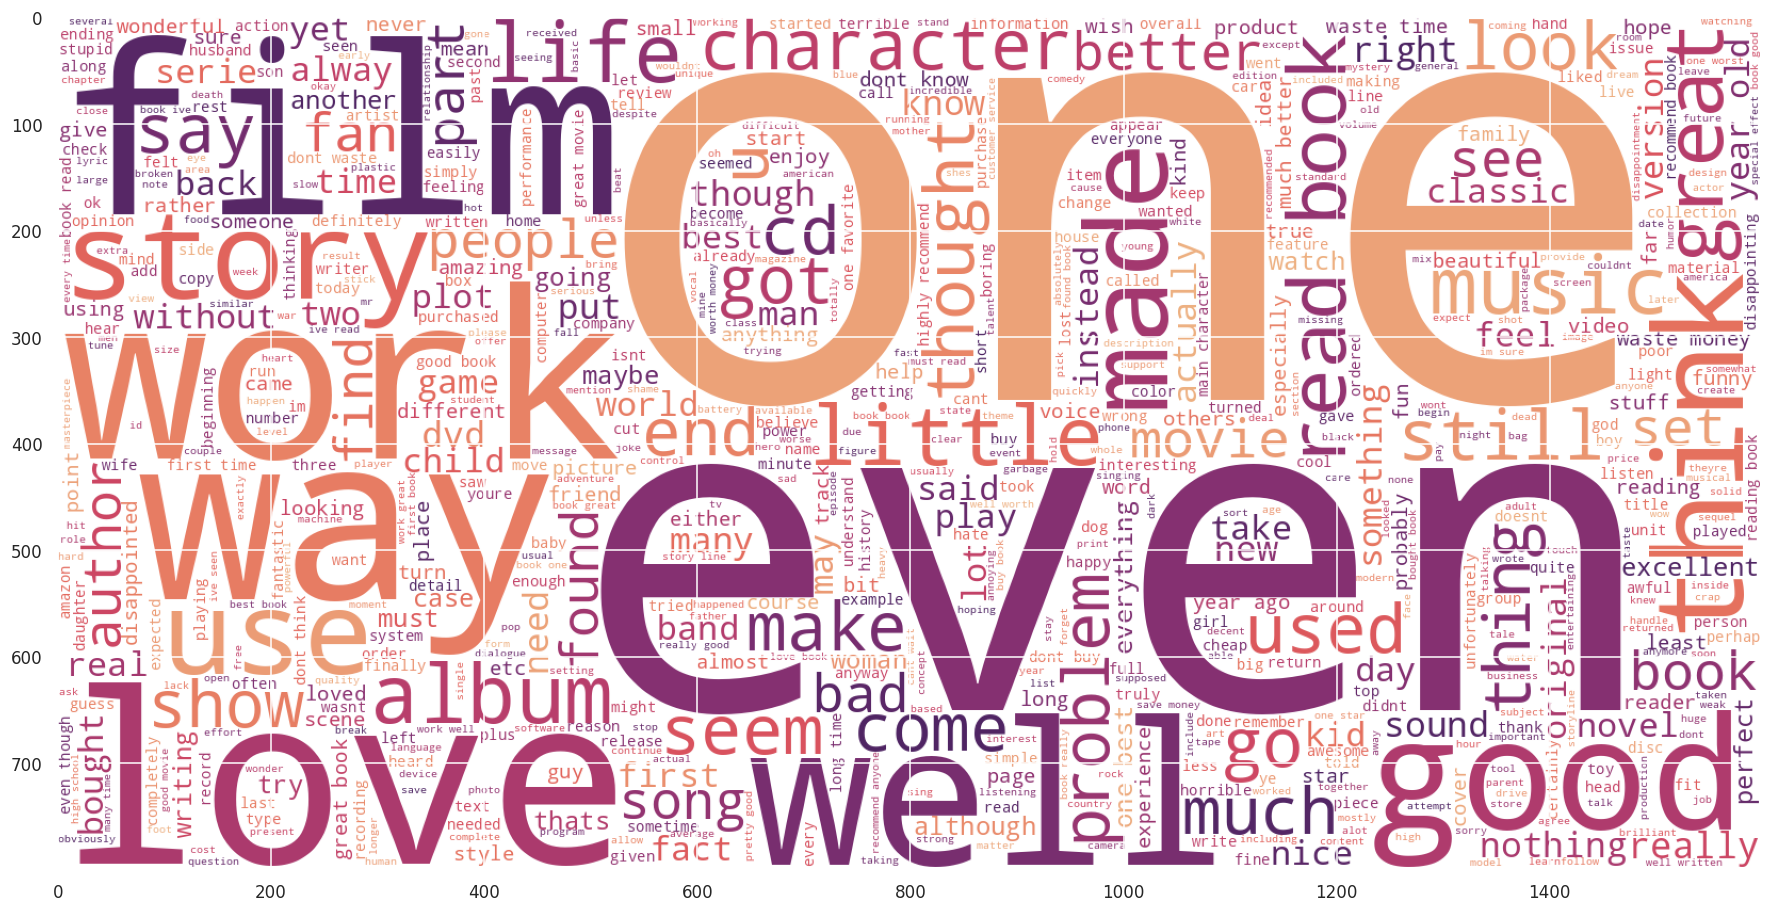

In [6]:
from wordcloud import WordCloud
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, min_font_size=10, 
                height=800,width=1600,background_color="white", colormap='flare').generate(' '.join(df['clean_lemma']))

plt.imshow(wc)

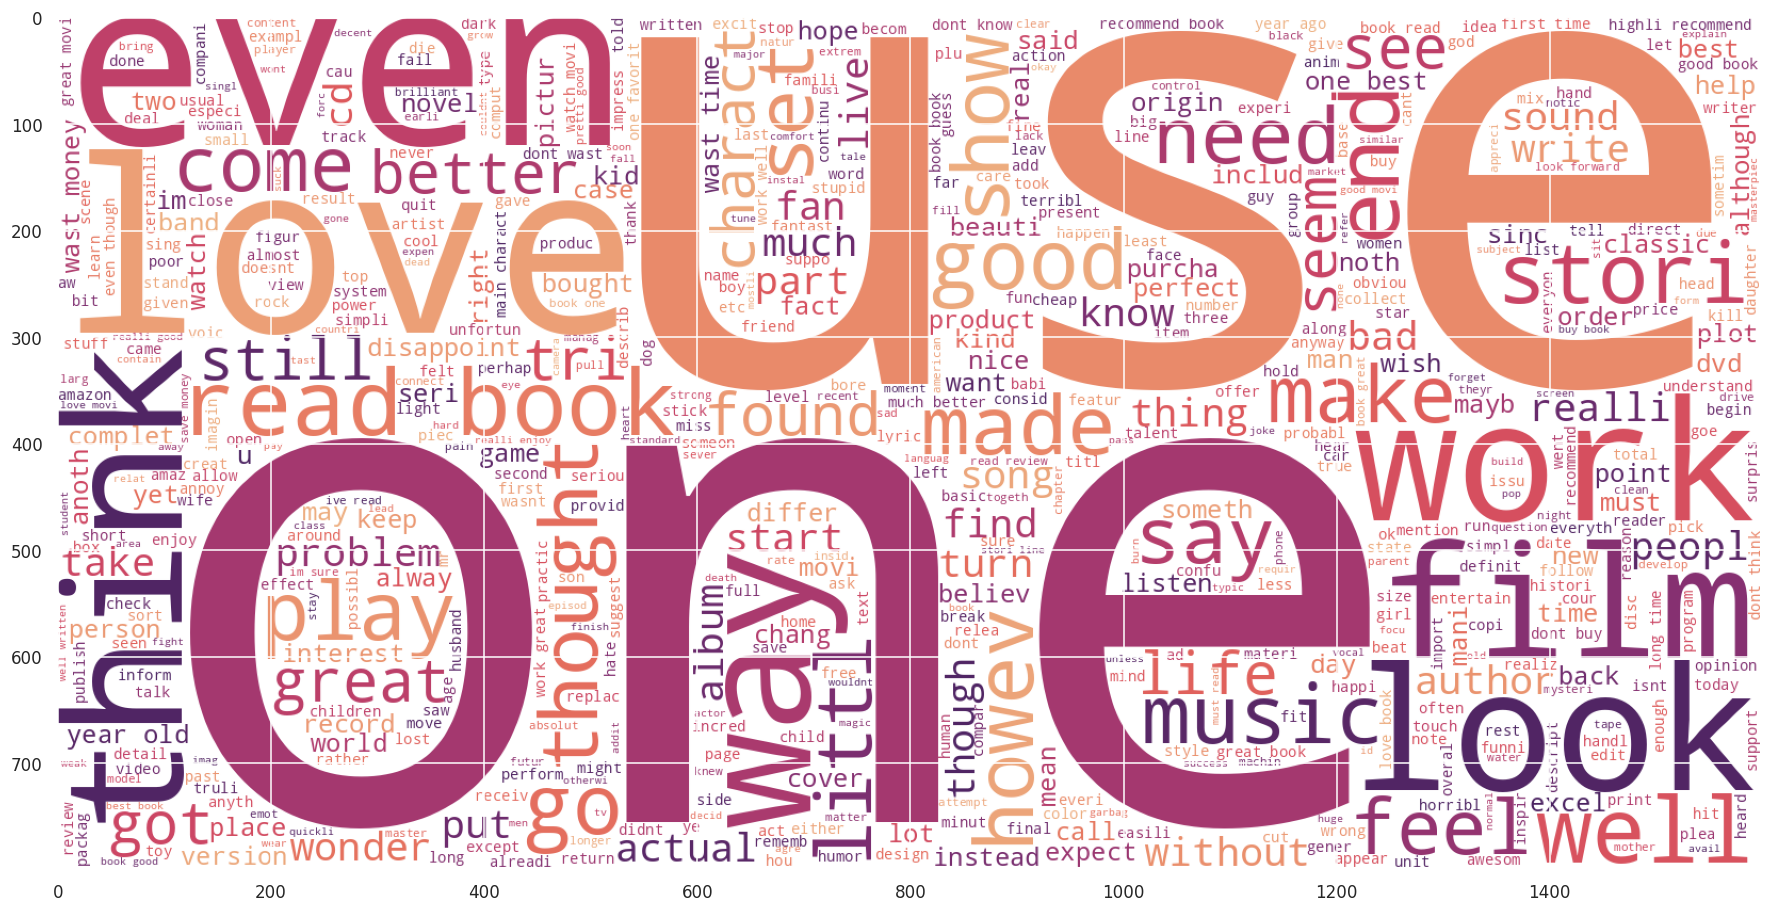

In [7]:
from wordcloud import WordCloud
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, min_font_size=10, 
                height=800,width=1600,background_color="white", colormap='flare').generate(' '.join(df['clean_stem']))

plt.imshow(wc)

# Modelleme · Stem vs Lemma × BoW vs TF-IDF


In [8]:
# 4.1  Konfigürasyon
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC  

feature_setups = {
    "bow_stem_nb":   ("clean_stem",  CountVectorizer(max_features=6000), MultinomialNB()),  
    "tfidf_stem_lr": ("clean_stem",  TfidfVectorizer(max_features=6000), LogisticRegression(max_iter=1000)),
    "tfidf_lemma_lr": ("clean_lemma",  TfidfVectorizer(max_features=6000), LogisticRegression(max_iter=1000)),
    "bow_stem_cnb":  ("clean_stem",  CountVectorizer(max_features=6000), ComplementNB()),
    "tfidf_lemma_svc": ("clean_lemma", TfidfVectorizer(max_features=6000), LinearSVC()),
    "tfidf_stem_svc": ("clean_stem", TfidfVectorizer(max_features=6000), LinearSVC()),
    "tfidf_stem_sgd":("clean_stem",  TfidfVectorizer(max_features=6000), SGDClassifier(loss="hinge", max_iter=1000)),
    "bow_stem_lr":  ("clean_stem",  CountVectorizer(max_features=6000), LogisticRegression(max_iter=1000)),
    "bow_lemma_lr":  ("clean_lemma",  CountVectorizer(max_features=6000), LogisticRegression(max_iter=1000)),
    "bow_stem_svc": ("clean_stem",  CountVectorizer(max_features=6000), LinearSVC()),
    "bow_lemma_svc": ("clean_lemma",  CountVectorizer(max_features=6000), LinearSVC()),
    "bow_stem_sgd": ("clean_stem",  CountVectorizer(max_features=6000), SGDClassifier(loss="hinge", max_iter=1000)),
    "tfidf_stem_nb":  ("clean_stem",  TfidfVectorizer(max_features=6000), MultinomialNB()),
    "tfidf_lemma_nb":  ("clean_lemma",  TfidfVectorizer(max_features=6000), MultinomialNB()),
    "tfidf_stem_cnb": ("clean_stem",  TfidfVectorizer(max_features=6000), ComplementNB()),
}
print(f"{len(feature_setups)} kombinasyon tanımlandı.")


15 kombinasyon tanımlandı.


## Multinomial Naive Bayes

>where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice
>https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes

##

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import time, pandas as pd

results = []

for name, (text_col, vect, model) in feature_setups.items():
    print(f"\n⏳ {name} – vektörizasyon ve eğitim başlıyor")

    # --------- Train–Test bölmesi ---------
    X_train, X_test, y_train, y_test = train_test_split(
        df[text_col],
        df["label"],
        test_size=0.2,
        random_state=42,
        stratify=df["label"]
    )

    # --------- Vektörizasyon süresi ölç ---------
    t_vec = time.time()
    X_train_vec = vect.fit_transform(X_train)
    X_test_vec  = vect.transform(X_test)
    vec_time = time.time() - t_vec

    # --------- Model fit süresi ölç ---------
    t_fit = time.time()
    model.fit(X_train_vec, y_train)
    fit_time = time.time() - t_fit

    y_pred = model.predict(X_test_vec)

    results.append({
        "setup":       name,
        "vectorizer":  type(vect).__name__,
        "model":       type(model).__name__,
        "accuracy":    round(accuracy_score(y_test, y_pred), 4),
        "f1":          round(f1_score(y_test, y_pred), 4),
        "precision":   round(precision_score(y_test, y_pred), 4),
        "recall":      round(recall_score(y_test, y_pred), 4),
        "vec_s":       round(vec_time, 1),
        "fit_s":       round(fit_time, 1),
    })

results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False)
display(results_df)



⏳ bow_stem_nb – vektörizasyon ve eğitim başlıyor

⏳ tfidf_stem_lr – vektörizasyon ve eğitim başlıyor

⏳ tfidf_lemma_lr – vektörizasyon ve eğitim başlıyor

⏳ bow_stem_cnb – vektörizasyon ve eğitim başlıyor

⏳ tfidf_lemma_svc – vektörizasyon ve eğitim başlıyor

⏳ tfidf_stem_svc – vektörizasyon ve eğitim başlıyor

⏳ tfidf_stem_sgd – vektörizasyon ve eğitim başlıyor

⏳ bow_stem_lr – vektörizasyon ve eğitim başlıyor

⏳ bow_lemma_lr – vektörizasyon ve eğitim başlıyor

⏳ bow_stem_svc – vektörizasyon ve eğitim başlıyor


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



⏳ bow_lemma_svc – vektörizasyon ve eğitim başlıyor


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



⏳ bow_stem_sgd – vektörizasyon ve eğitim başlıyor

⏳ tfidf_stem_nb – vektörizasyon ve eğitim başlıyor

⏳ tfidf_lemma_nb – vektörizasyon ve eğitim başlıyor

⏳ tfidf_stem_cnb – vektörizasyon ve eğitim başlıyor


,setup,vectorizer,model,accuracy,f1,precision,recall,vec_s,fit_s
2,tfidf_lemma_lr,TfidfVectorizer,LogisticRegression,0.8875,0.8892,0.8861,0.8922,7.8,3.8
4,tfidf_lemma_svc,TfidfVectorizer,LinearSVC,0.8850,0.8869,0.8825,0.8913,7.9,3.1
1,tfidf_stem_lr,TfidfVectorizer,LogisticRegression,0.8844,0.8862,0.8825,0.8899,7.6,5.8
8,bow_lemma_lr,CountVectorizer,LogisticRegression,0.8832,0.8854,0.8787,0.8923,7.7,12.9
5,tfidf_stem_svc,TfidfVectorizer,LinearSVC,0.8831,0.8850,0.8806,0.8895,7.5,3.1
10,bow_lemma_svc,CountVectorizer,LinearSVC,0.8818,0.8842,0.8764,0.8921,7.7,49.8
11,bow_stem_sgd,CountVectorizer,SGDClassifier,0.8806,0.8834,0.8728,0.8943,7.6,1.6
7,bow_stem_lr,CountVectorizer,LogisticRegression,0.8799,0.8823,0.8747,0.8900,7.4,13.9
9,bow_stem_svc,CountVectorizer,LinearSVC,0.8787,0.8813,0.8725,0.8903,7.4,51.4
6,tfidf_stem_sgd,TfidfVectorizer,SGDClassifier,0.8778,0.8795,0.8768,0.8823,7.5,0.5
